In [12]:
import Levenshtein 
from Levenshtein import distance, ratio
import nltk
nltk.download('punkt_tab')
from nltk.metrics import edit_distance, edit_distance_align

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Le\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [13]:
text1 = "Список правителей Пруссии включает лиц, являвшихся монархами появившегося в 1525 году герцогства Пруссия, преобразованного в 1701 году в королевство, просуществовавшее до 1918 года. Также список дополнен перечнем министров-президентов Пруссии, возглавлявших в 1918—1945 годах высший исполнительный орган Свободного государства, фактически упразднённого в 1934 году с проведением административной реформы и формально в 1947 году указом Союзнического Контрольного совета." 
text2 = "В список правителей Пруссии включены лица, которые были монархами герцогства Пруссия, возникшего в 1525 году и преобразованного в 1701 году в королевство, просуществовавшее до 1918 года. Список также дополняется списком министров-президентов Пруссии, возглавлявших высший исполнительный орган Свободного государства в 1918-1945 годах, который был фактически упразднен в 1934 году административной реформой и формально - в 1947 году указом Союзного контрольного совета."
text3 = "Альбрехт родился 17 мая 1490 года в Ансбахе. Его отцом был Фридрих I Гогенцоллерн, маркграф Бранденбург-Ансбаха. Его мать София Ягеллонка была дочерью польского короля Казимира IV Ягеллона. Прадедом Альбрехта является король польский и великий князь литовский Ягайло"
text4 = "Альбрехт родился 17 мая 1490 года в Ансбахе. Его отцом был Фридрих I Гогенцоллерн, маркграф Бранденбург-Ансбахский. Его мать София Ягеллонка была дочерью польского короля Казимира IV Ягеллона. Прадед Альбрехта - король Польши Ягелло и великий князь Литовский"
text5 = "1 2 3"
text6 = "1 3 2"


### Расстояние Левинштейна с весами (по словам)

In [14]:
def levinshtein_distance(t1, t2, insert=1, delete=1, change=1):
    if isinstance(t1, str):
        t1 = t1.split()
        t2 = t2.split()
    return distance(
                t1, 
                t2,
                weights=(
                    insert,      # вставка
                    delete,      # удаление
                    change       # замена
                )
            )

levinshtein_distance(text1, text2)

31

### Нахождение индексов изменений (по Левинштейну)

In [15]:
def levenshtein_distance_positions(list1, list2, del_cost=1, ins_cost=1, sub_cost=1):
    
    if isinstance(list1, str):
        list1 = list1.split()
        list2 = list2.split()
        
    len1, len2 = len(list1), len(list2)
    dp = [[0] * (len2 + 1) for _ in range(len1 + 1)]

    # Инициализация первой строки и столбца
    for i in range(1, len1 + 1):
        dp[i][0] = i * del_cost
    for j in range(1, len2 + 1):
        dp[0][j] = j * ins_cost

    # Заполнение таблицы
    for i in range(1, len1 + 1):
        for j in range(1, len2 + 1):
            if list1[i - 1] == list2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]  # Без стоимости, если элементы совпадают
            else:
                dp[i][j] = min(
                    dp[i - 1][j] + del_cost,      # Удаление
                    dp[i][j - 1] + ins_cost,      # Вставка
                    dp[i - 1][j - 1] + sub_cost   # Замена
                )

    # Обратное восстановление пути
    i, j = len1, len2
    res_dict = {
        "distance": dp[len1][len2],
        "delete": [],
        "insert": [],
        "change": []
    }

    while i > 0 or j > 0:
        if i > 0 and j > 0 and list1[i - 1] == list2[j - 1]:
            i -= 1
            j -= 1
        elif i > 0 and dp[i][j] == dp[i - 1][j] + del_cost:
            res_dict["delete"].append((i - 1,))
            i -= 1
        elif j > 0 and dp[i][j] == dp[i][j - 1] + ins_cost:
            res_dict["insert"].append((j - 1,))
            j -= 1
        elif i > 0 and j > 0 and dp[i][j] == dp[i - 1][j - 1] + sub_cost:
            res_dict["change"].append((i - 1, j - 1))
            i -= 1
            j -= 1

    return res_dict

In [16]:
levenshtein_distance_positions(
    ["8", "1"],
    ["2", "1", "9"]
)

{'distance': 2, 'delete': [], 'insert': [(2,)], 'change': [(0, 0)]}

In [17]:
print(levenshtein_distance_positions(
    text1.split(), text2.split()
))

{'distance': 31, 'delete': [(44,), (43,), (32,), (31,), (30,), (12,)], 'insert': [(52,), (42,), (41,), (40,), (39,), (38,), (11,), (10,), (7,), (1,)], 'change': [(54, 58), (53, 57), (46, 49), (39, 44), (37, 37), (26, 29), (25, 28), (24, 27), (23, 26), (11, 15), (7, 9), (5, 6), (4, 5), (3, 4), (0, 0)]}


### Расстояние Левинштейна с перестановками (по словам)

In [18]:
edit_distance(["1", "2"], ["2", "1"], substitution_cost=1, transpositions=True)

1

### Нормализованное на длину текстов расстояние Левинштейна

In [19]:
def levinshtein_distance_norm(t1, t2, insert=1, delete=1, change=1):
    if isinstance(t1, str):
        t1 = t1.split()
        t2 = t2.split()
    return distance(
                t1, 
                t2,
                weights=(
                    insert,      # вставка
                    delete,      # удаление
                    change       # замена
                )
            ) * 1.0 / (len(t1) + len(t2))

print(levinshtein_distance_norm(text1, text2), "vs", levinshtein_distance(text1, text2))
print(levinshtein_distance_norm(text3, text4), "vs", levinshtein_distance(text3, text4))
print(levinshtein_distance_norm(text5, text6), "vs", levinshtein_distance(text5, text6))

print(levinshtein_distance_norm(text1, text3), "vs", levinshtein_distance(text1, text3))
print(levinshtein_distance_norm(text1, text6), "vs", levinshtein_distance(text1, text6))

0.2672413793103448 vs 31
0.0945945945945946 vs 7
0.3333333333333333 vs 2
0.5806451612903226 vs 54
0.9491525423728814 vs 56


### Матрица близости текстов

In [77]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

def get_metrics_matrix(texts_list, distance_func, title=None):
    matrix = np.zeros((len(texts_list), len(texts_list)))
    for i in range(len(texts_list)):
        for j in range(len(texts_list)):
            matrix[i, j] = distance_func(texts_list[i], texts_list[j])
            
    hm = sns.heatmap(data=matrix, 
                    annot=True,
                    cmap="crest") 

    if title:
        plt.title(title)
    plt.show()
            
    return matrix

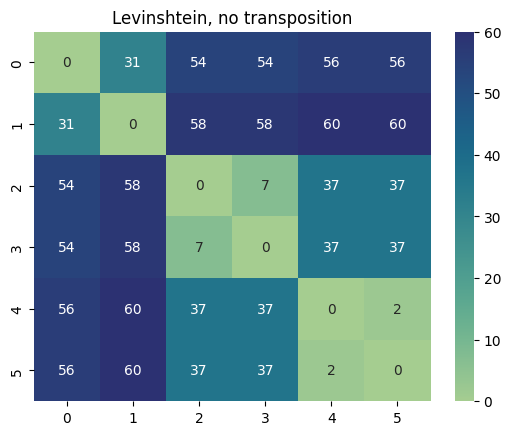

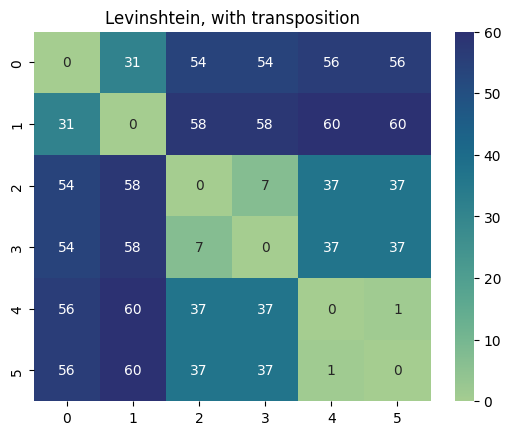

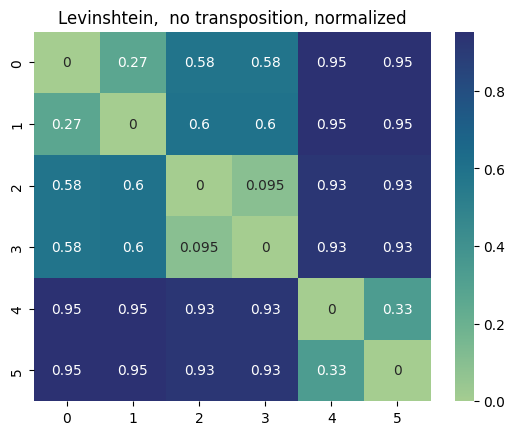

In [78]:
data = get_metrics_matrix(
    [text1, text2, text3, text4, text5, text6], 
    lambda x, y: levenshtein_distance_positions(x.split(),y.split())['distance'], 
    title='Levinshtein, no transposition'
)
data = get_metrics_matrix(
    [text1, text2, text3, text4, text5, text6], 
    lambda x, y: edit_distance(x.split(),y.split(), substitution_cost=1, transpositions=True), 
    title='Levinshtein, with transposition'
)
data = get_metrics_matrix(
    [text1, text2, text3, text4, text5, text6], 
    lambda x, y: levinshtein_distance_norm(x, y), 
    title='Levinshtein,  no transposition, normalized'
)

### Токенизация. Обучаю на всем наборе текстов

In [79]:
corpus = [
    text1, text2, text3, text4, text5, text6
]

In [80]:
from collections import defaultdict

word_freqs = defaultdict(int)
for text in corpus:
    for word in text.split():
        word_freqs[word] += 1

# word_freqs

In [81]:
alphabet = []
for word in word_freqs.keys():
    if word[0] not in alphabet:
        alphabet.append(word[0])
    for letter in word[1:]:
        if f"##{letter}" not in alphabet:
            alphabet.append(f"##{letter}")

alphabet.sort()
# alphabet

In [82]:
vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
# vocab

In [83]:
splits = {
    word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
    for word in word_freqs.keys()
}
# splits

In [23]:
def compute_pair_scores(splits, word_freqs):
    letter_freqs = defaultdict(int)
    pair_freqs = defaultdict(int)
    for word, freq in word_freqs.items():
        split = splits[word]
        if len(split) == 1:
            letter_freqs[split[0]] += freq
            continue
        for i in range(len(split) - 1):
            pair = (split[i], split[i + 1])
            letter_freqs[split[i]] += freq
            pair_freqs[pair] += freq
        letter_freqs[split[-1]] += freq

    scores = {
        pair: freq / (letter_freqs[pair[0]] * letter_freqs[pair[1]])
        for pair, freq in pair_freqs.items()
    }
    return scores

In [85]:
pair_scores = compute_pair_scores(splits, word_freqs)
for i, key in enumerate(pair_scores.keys()):
    print(f"{key}: {pair_scores[key]}")
    if i >= 5:
        break

('С', '##п'): 0.019230769230769232
('##п', '##и'): 0.005341880341880342
('##и', '##с'): 0.002232142857142857
('##с', '##о'): 0.000496031746031746
('##о', '##к'): 0.0009578544061302681
('п', '##р'): 0.008333333333333333


In [86]:
best_pair = ""
max_score = None
for pair, score in pair_scores.items():
    if max_score is None or max_score < score:
        best_pair = pair
        max_score = score

print(best_pair, max_score)

('##8', '##—') 0.25


In [31]:
def merge_pair(a, b, splits, word_freqs):
    for word in word_freqs:
        split = splits[word]
        if len(split) == 1:
            continue
        i = 0
        while i < len(split) - 1:
            if split[i] == a and split[i + 1] == b:
                merge = a + b[2:] if b.startswith("##") else a + b
                split = split[:i] + [merge] + split[i + 2 :]
            else:
                i += 1
        splits[word] = split
    return splits

In [88]:
vocab_size = 500
while len(vocab) < vocab_size:
    scores = compute_pair_scores(splits, word_freqs)
    best_pair, max_score = "", None
    for pair, score in scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
    splits = merge_pair(*best_pair, splits)
    new_token = (
        best_pair[0] + best_pair[1][2:]
        if best_pair[1].startswith("##")
        else best_pair[0] + best_pair[1]
    )
    vocab.append(new_token)

In [89]:
print(len(vocab))
print(vocab)

500
['[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]', '##,', '##-', '##.', '##0', '##1', '##2', '##3', '##4', '##5', '##7', '##8', '##9', '##V', '##А', '##а', '##б', '##в', '##г', '##д', '##е', '##ж', '##з', '##и', '##й', '##к', '##л', '##м', '##н', '##о', '##п', '##р', '##с', '##т', '##у', '##ф', '##х', '##ц', '##ч', '##ш', '##щ', '##ы', '##ь', '##ю', '##я', '##ё', '##—', '-', '1', '2', '3', 'I', 'А', 'Б', 'В', 'Г', 'Е', 'К', 'Л', 'П', 'С', 'Т', 'Ф', 'Я', 'а', 'б', 'в', 'г', 'д', 'и', 'к', 'л', 'м', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'я', '##8—', 'IV', '##-А', '##52', '##525', '##18', '##18—', '##18—1', '##01', '##-1', '##18-1', '##701', '##45', '##34', '##47', '##918', '##918—1', '##918—19', '##918—1945', '##934', '##947', '##918-1', '##918-19', '##918-1945', '##49', '##490', '##-п', 'бы', '1525', '1701', '1918', '1918—1945', '1934', '1947', '1918-1945', '17', '1490', '##ущ', 'сп', 'уп', 'Сп', '##юч', '##кж', 'ук', '##юз', '##ью', 'ад', 'адм', 'Ег', '##г-А', 'Яг', 'яв', '##в-п', '##ый',

In [32]:
def encode_word(word, vocab):
    tokens = []
    while len(word) > 0:
        i = len(word)
        while i > 0 and word[:i] not in vocab:
            i -= 1
        if i == 0:
            return ["[UNK]"]
        tokens.append(word[:i])
        word = word[i:]
        if len(word) > 0:
            word = f"##{word}"
    return tokens

In [91]:
print(encode_word("Hugging"))
print(encode_word("HOgging"))
print(encode_word("is"))

['[UNK]']
['[UNK]']
['[UNK]']


In [52]:
def tokenize(text, vocab):
    if isinstance(text, str):
        text = text.split()
    encoded_words = [encode_word(word, vocab) for word in text]
    return sum(encoded_words, [])

In [93]:
print(len(tokenize(text1)))
print(tokenize(text1))

122
['Список', 'правителей', 'Пруссии', 'включает', 'лиц,', 'являвшихся', 'монархами', 'появившегося', 'в', '1525', 'году', 'герцогства', 'Пруссия,', 'прео', '##браз', '##о', '##ванн', '##о', '##г', '##о', 'в', '1701', 'году', 'в', 'к', '##о', '##р', '##о', '##левств', '##о', '##,', 'пр', '##о', '##существ', '##о', '##вавшее', 'д', '##о', '1918', 'года.', 'Также', 'спис', '##о', '##к', 'д', '##о', '##п', '##о', '##лнен', 'перечнем', 'министр', '##о', '##в-президент', '##о', '##в', 'Пруссии,', 'в', '##о', '##зглавлявших', 'в', '1918—1945', 'годах', 'высший', 'исп', '##о', '##лнительный', 'орган', 'Св', '##о', '##б', '##о', '##дн', '##о', '##г', '##о', 'государства,', 'фактически', 'упразднённ', '##о', '##г', '##о', 'в', '1934', 'году', 'с', 'пр', '##о', '##ведением', 'административн', '##о', '##й', 'реф', '##о', '##рмы', 'и', 'ф', '##о', '##рмальн', '##о', 'в', '1947', 'году', 'указ', '##о', '##м', 'С', '##о', '##юзническ', '##о', '##г', '##о', 'К', '##о', '##нтр', '##о', '##льн', '##о'

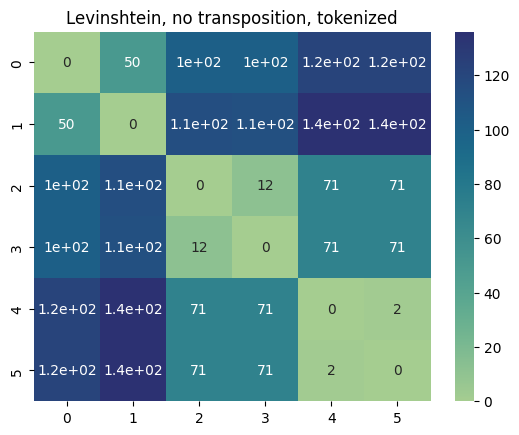

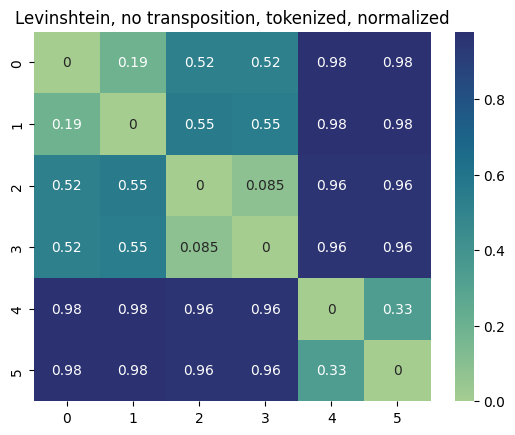

In [95]:
data = get_metrics_matrix(
    [tokenize(text1), tokenize(text2), tokenize(text3), tokenize(text4), tokenize(text5), tokenize(text6)], 
    lambda x, y: levenshtein_distance_positions(x,y)['distance'], 
    title='Levinshtein, no transposition, tokenized'
)

data = get_metrics_matrix(
    [tokenize(text1), tokenize(text2), tokenize(text3), tokenize(text4), tokenize(text5), tokenize(text6)], 
    lambda x, y: levinshtein_distance_norm(x,y), 
    title='Levinshtein, no transposition, tokenized, normalized'
)

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_metrics_matrices(texts_list, distance_funcs, titles, axis_labels=None):
    num_plots = len(distance_funcs)
    rows = (num_plots + 2) // 3  # Определяем количество строк, по 3 графика в каждой строке
    cols = min(3, num_plots)     # Не более 3 графиков в строке
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))  # Настраиваем размер полотна
    axes = axes.flatten() if num_plots > 1 else [axes]  # Упрощаем доступ к осям

    matrices = []  # Список для хранения всех матриц расстояний

    # Используем числовые метки по умолчанию, если axis_labels не задан
    axis_labels = axis_labels if axis_labels is not None else [str(i + 1) for i in range(len(texts_list))]

    for idx, (distance_func, title) in enumerate(zip(distance_funcs, titles)):
        # Создаем и заполняем матрицу расстояний
        matrix = np.zeros((len(texts_list), len(texts_list)))
        for i in range(len(texts_list)):
            for j in range(len(texts_list)):
                matrix[i, j] = distance_func(texts_list[i], texts_list[j])
                
        sns.heatmap(data=matrix, 
                    annot=True,
                    cmap="crest", 
                    ax=axes[idx],
                    xticklabels=axis_labels,
                    yticklabels=axis_labels)  # Устанавливаем пользовательские метки осей
        
        if title:
            axes[idx].set_title(title)
        
        matrices.append(matrix)  # Добавляем текущую матрицу в список

    # Отключаем оставшиеся пустые оси
    for ax in axes[num_plots:]:
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    return matrices


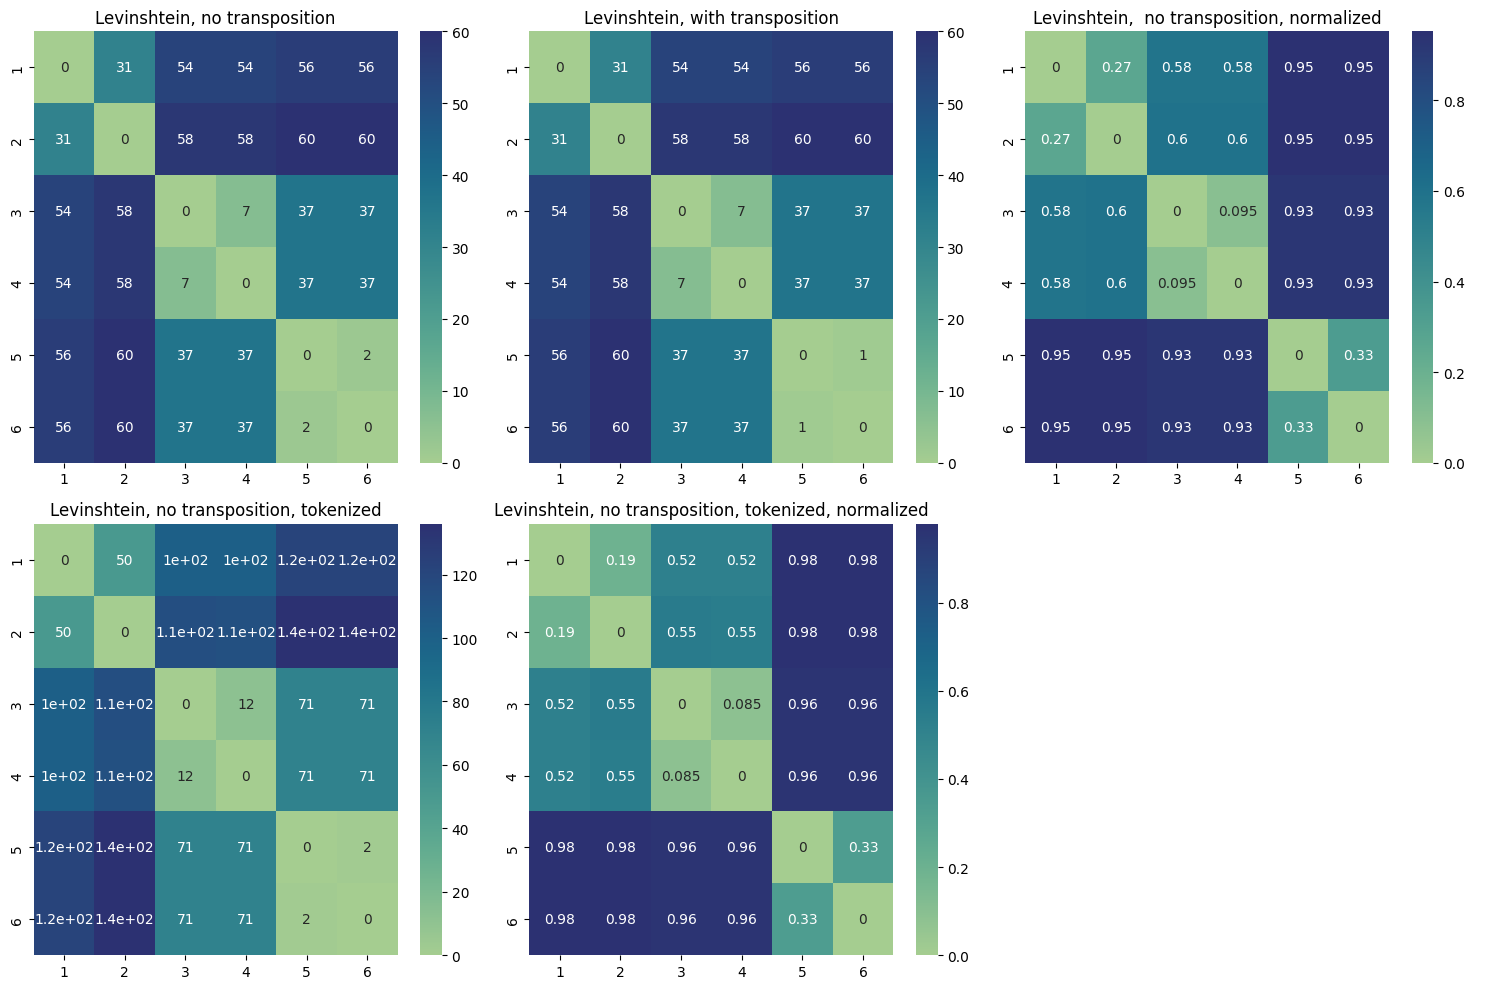

In [97]:
data = get_metrics_matrices(
    [text1, text2, text3, text4, text5, text6],
    [
        lambda x, y: levenshtein_distance_positions(x, y)['distance'],
        lambda x, y: edit_distance(x.split(),y.split(), substitution_cost=1, transpositions=True),
        lambda x, y: levinshtein_distance_norm(x, y),
        lambda x, y: levenshtein_distance_positions(tokenize(x),tokenize(y))['distance'],
        lambda x, y: levinshtein_distance_norm(tokenize(x),tokenize(y))
    ],
    [
        'Levinshtein, no transposition',
        'Levinshtein, with transposition',
        'Levinshtein,  no transposition, normalized',
        'Levinshtein, no transposition, tokenized',
        'Levinshtein, no transposition, tokenized, normalized'
    ]
)

### Блок с подробным сравнением пары текстов

In [29]:
from termcolor import colored

def highlight_changes(text1, text2, changes):
    
    if isinstance(text1, str):
        text1 = text1.split()
        text2 = text2.split()
    
    # Создаем копии текстов для их редактирования
    highlighted_text1 = text1[:]
    highlighted_text2 = text2[:]

    # Помечаем удаленные слова (удалены из text1)
    for delete_index in changes['delete']:
        idx = delete_index[0]
        if 0 <= idx < len(highlighted_text1):
            highlighted_text1[idx] = colored(highlighted_text1[idx] + f"({idx})", 'red')

    # Помечаем вставленные слова (вставлены в text2)
    for insert_index in changes['insert']:
        idx = insert_index[0]
        if 0 <= idx < len(highlighted_text2):
            highlighted_text2[idx] = colored(highlighted_text2[idx]+ f"({idx})", 'green')
            
    highlighted_text1_indexed = highlighted_text1.copy()
    highlighted_text2_indexed = highlighted_text2.copy()  
    
    # Помечаем измененные слова
    for change_pair in changes['change']:
        idx1, idx2 = change_pair
        if 0 <= idx1 < len(highlighted_text1):
            highlighted_text1_indexed[idx1] = colored(highlighted_text1[idx1], 'yellow')
            highlighted_text1[idx1] = colored(highlighted_text1[idx1]+ f"::{highlighted_text2[idx2]}", 'yellow')
        if 0 <= idx2 < len(highlighted_text2):
            highlighted_text2[idx2] = colored(highlighted_text2[idx2]+ f"::{highlighted_text1_indexed[idx1]}", 'yellow')

    # Возвращаем измененные тексты
    return ' '.join(highlighted_text1), ' '.join(highlighted_text2)


In [30]:
t1, t2 = highlight_changes(
    text1,
    text2,
    levenshtein_distance_positions(text1, text2)
)
print(t1)
print()
print(t2)

Список::В правителей Пруссии включает::включены лиц,::лица, являвшихся::которые монархами появившегося::герцогства в 1525 году герцогства::и Пруссия,(12) преобразованного в 1701 году в королевство, просуществовавшее до 1918 года. Также::Список список::также дополнен::дополняется перечнем::списком министров-президентов Пруссии, возглавлявших в(30) 1918—1945(31) годах(32) высший исполнительный орган Свободного государства,::государства фактически упразднённого::упразднен в 1934 году с(43) проведением(44) административной реформы::реформой и формально в 1947 году указом Союзнического::Союзного Контрольного::контрольного совета.

В::Список список(1) правителей Пруссии включены::включает лица,::лиц, которые::являвшихся были(7) монархами герцогства::появившегося Пруссия,(10) возникшего(11) в 1525 году и::герцогства преобразованного в 1701 году в королевство, просуществовавшее до 1918 года. Список::Также также::список дополняется::дополнен списком::перечнем министров-президентов Пруссии, возг

# Переход на славянские тексты

In [1]:
import docx

def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

document = getText('Сирах из Княж. Изборника.docx')
# document

doc = docx.Document('Сирах из Княж. Изборника.docx')

t = '\n'.join([x.text for x in doc.paragraphs[18:23]])
print(t)

<6:0> Wisdom of Jesus Son of Sirach (6:207–208 interpolated)
K	ⱂⱃⱑⰿⰴⱃⱁⱄⱅⱐ ⰻⰹⱄⱛⱄⱁⰲⰰ ⱄⱖⱀⰰ ⱄⰹⱃⰰⱈⱁⰲⰰ 
O	прѣмѫдрость іисоусова сꙑна сирахова 
Д	прмдрсть іс҃а сн҃а сирахова| 
I	прѣмѹдрость и҃сва| с҃на сирахова⁘| 


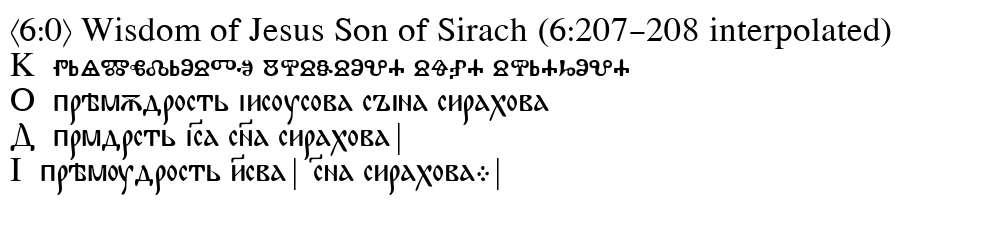

In [2]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Загрузка шрифта
font_path = "Bukyvede.ttf"  # путь к вашему .ttf файлу
font_size = 35
font = ImageFont.truetype(font_path, font_size)

# Создание изображения
image = Image.new('RGB', (1000, 230), color=(255, 255, 255))
draw = ImageDraw.Draw(image)
draw.text((10, 10), t.replace('\t', '  '), font=font, fill=(0, 0, 0))

display(image)

хочу посмотреть на символы отдельно

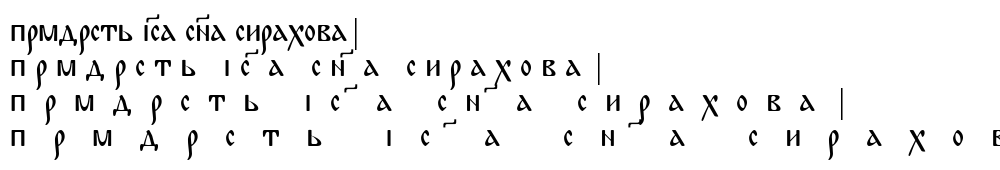

In [3]:
image = Image.new('RGB', (1000, 170), color=(255, 255, 255))
draw = ImageDraw.Draw(image)

text0 = doc.paragraphs[21].text[2:]
text = text0 + "\n" + ' '.join(text0) + "\n" + '  '.join(text0) + "\n" + '   '.join(text0)

draw.text((10, 10), text, font=font, fill=(0, 0, 0))
display(image)

1. выделить отдельные тексты по их кодам; проблема в том, что не у всех предложений есть все тексты; если же наоборот - объединять через пробел (у ключа чтобы было одно значение)

1.1 перед этим надо понять, а как нам смогут помочь нумерации глав ис строк? А, ну нет там ничего такого, конечно. Так что ок оюъединять

2. посмотреть метрики обыкновенные
3. токенизировать
4. посмотреть токенизированные метрики

In [4]:
import re
pattern = r"^<[^>]+:[^>]+>"

print(True if re.match(pattern, doc.paragraphs[18].text) else False)  # английская
print(doc.paragraphs[19].text[:2] == 'K\t')  # английская
print(doc.paragraphs[20].text[:2] == 'O\t')  # английская
print(doc.paragraphs[21].text[:2] == 'Д\t')  # русская
print(doc.paragraphs[22].text[:2] == 'I\t')  # английская
print(doc.paragraphs[23].text[:2] == 'П\t')  # русская
print(doc.paragraphs[24].text[:2] == 'В\t')  # русская

True
True
True
True
True
True
True


In [5]:
def getText(filename):
    
    superdict = {
        'K': [],
        'O': [],
        'Д': [],
        'I': [],
        'П': [],
        'В': [],
        'other': []
     }
    
    doc = docx.Document(filename)
    for para in doc.paragraphs:
        text = para.text
        if text[:2] == 'K\t':
            superdict['K'] += [text[2:]]
        elif text[:2] == 'O\t':
            superdict['O'] += [text[2:]]
        elif text[:2] == 'Д\t':
            superdict['Д'] += [text[2:]]
        elif text[:2] == 'I\t':
            superdict['I'] += [text[2:]]
        elif text[:2] == 'П\t':
            superdict['П'] += [text[2:]]
        elif text[:2] == 'В\t':
            superdict['В'] += [text[2:]]
        else:
            superdict['other'] += [text]
            
    return superdict

In [6]:
def printText(text, canvas_w=1000, canvas_h=170, font_path="Bukyvede.ttf", font_size=35):
    
    font_path = font_path  
    font_size = font_size
    font = ImageFont.truetype(font_path, font_size)
    
    image = Image.new('RGB', (canvas_w, canvas_h), color=(255, 255, 255))
    draw = ImageDraw.Draw(image)

    draw.text((10, 10), text, font=font, fill=(0, 0, 0))
    display(image)

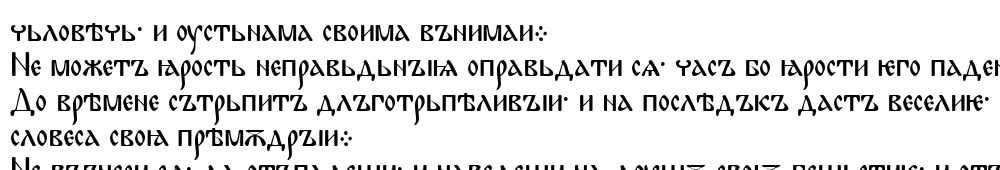

In [7]:
superdict = getText("Сирах из Княж. Изборника.docx")
printText('\n'.join(superdict['O'][18:]))

Для первого сравнения предлагаю выбрать 10 первых строк к каждого текста, склеить через пробел и разбить по словам. 

In [8]:
dataset = superdict.copy()

for key in dataset.keys():
    dataset[key] = ''.join(dataset[key][1:11])
    dataset[key] = dataset[key].split(' ')
    
print(dataset['I'])

['прѣмѹдрость', 'и҃сва|', 'с҃на', 'сирахова⁘|', 'Вьсѧка', 'мѹдрость', 'отъ|', 'г҃а·', 'и', 'съ', 'нимь', 'ѥсть', 'въ|', 'вѣкꙑ', 'пѣсъка', 'мо||рьскааго', 'и', 'каплѧ', 'дъжде|вьныꙗ', '[и', 'дн҃и', 'вѣк]ъ', 'къ|то', 'иштьтеть⁘|\xa0Прѣмѹдрость', 'кто', 'ислѣ|дить·', 'коренъ', 'прѣмѹ|дрости', 'комѹ', 'отъкры|', 'сѧ·', 'и', 'раꙁѹмъ', 'ѥꙗ', 'ктѡ|', 'раꙁѹмѣ⁘|\xa0Ѥдинъ', 'ѥсть', 'прѣмѹдръ|', 'страшьнъ', 'ꙁѣло', 'сѣдѧи|', 'на', 'престолѣ', 'своѥмь', 'г҃ь|', 'самъ', 'съꙁьдалъ', 'ю', '[и', 'в]и[дѣ]||', 'и', 'иштьте', 'ю·', 'и', 'пролиꙗ', 'ѭ|', 'на', 'вьсѣхъ', 'дѣлѣхъ', 'свои|хъ·', 'и', 'даровалъ', 'ю', 'любѧ|штиимъ', 'ѥго⁘|\xa0ꙁачало', 'прѣмѹдрости', 'стра|хъ', 'г҃нь·', 'страхъ', 'г҃нь', 'слава|', 'и', 'похвала·', 'и', 'веселиѥ', 'и', 'вѣ|ньць', 'радости⁘|\xa0Страхъ', 'г҃нь', 'въꙁвеселить|', 'ср҃дце·', 'и', 'дасть', 'веселиѥ|', 'и', 'дългодьниѥ⁘|\xa0Боꙗштѧмѹ', 'сѧ', 'г҃а', 'благо||', 'бѹдеть', 'на', 'послѣдъкъ·|', 'и', 'въ', 'д҃нь', 'съконьчѧниꙗ|', 'своѥго', 'бл҃гсловленъ', 'бѹ|деть⁘|\xa0Въножьс

In [76]:
from collections import defaultdict

def fit_tokenizer(corpus, vocab_size):
    word_freqs = defaultdict(int)
    for text in corpus:
        if isinstance(text, str):
            text = text.split()
        for word in text:
            if word != '':  # вот тут осторожно - надо проверять аккуратнее такие кейсы
                word_freqs[word] += 1      
    
    alphabet = []
    for word in word_freqs.keys():
        if word[0] not in alphabet:
            alphabet.append(word[0])
        for letter in word[1:]:
            if f"##{letter}" not in alphabet:
                alphabet.append(f"##{letter}")
    alphabet.sort()
    
    vocab = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"] + alphabet.copy()
    
    splits = {
        word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
        for word in word_freqs.keys()
    }
    
    pair_scores = compute_pair_scores(splits, word_freqs)
    for i, key in enumerate(pair_scores.keys()):
#         print(f"{key}: {pair_scores[key]}")
        if i >= 5:
            break
            
    best_pair = ""
    max_score = None
    for pair, score in pair_scores.items():
        if max_score is None or max_score < score:
            best_pair = pair
            max_score = score
#     print(best_pair, max_score)
    
    vocab_size = vocab_size
    while len(vocab) < vocab_size:
        scores = compute_pair_scores(splits, word_freqs)
        best_pair, max_score = "", None
        for pair, score in scores.items():
            if max_score is None or max_score < score:
                best_pair = pair
                max_score = score
        try:
            splits = merge_pair(*best_pair, splits, word_freqs)
        except:
            print('max vocab size exceeded')
            break
        new_token = (
            best_pair[0] + best_pair[1][2:]
            if best_pair[1].startswith("##")
            else best_pair[0] + best_pair[1]
        )
        vocab.append(new_token)
    print('vocab size: ', len(vocab))
    
    return vocab

In [86]:
old_slavonic_vocab = fit_tokenizer(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    1300
)

vocab size:  1300


In [87]:
print(tokenize(dataset['O'], old_slavonic_vocab))

['прѣмѫдр', '##о', '##сть', 'іис', '##о', '##ус', '##о', '##в', '##а', 'сꙑн', '##а', 'сир', '##а', '##х', '##о', '##в', '##а', 'Вьсꙗк', '##а', 'мѫдр', '##о', '##сть', 'отъ', 'г', '##о', '##сп', '##о', '##д', '##а', '##·', 'и', 'съ', 'нимь', 'ѥстъ', 'въ', 'вѣкꙑ·', 'пѣсък', '##а', 'м', '##о', '##рьск', '##а', '##ѥг', '##о', 'и', 'к', '##а', '##плѧ', 'дъждевьнꙑѩ·', 'дьни', 'вѣк', '##а', 'кът', '##о', 'ищьтетъ⁘', 'Прѣмѫдр', '##о', '##сть', 'кът', '##о', 'ислѣдитъ·', 'к', '##о', '##рень', 'прѣмѫдр', '##о', '##сти', 'к', '##о', '##мѹ', 'отъкрꙑ', 'сѧ', '##·', 'и', 'р', '##а', '##ꙁѹмъ', 'ѥѩ', 'кът', '##о', 'р', '##а', '##ꙁѹмѣ⁘', 'Ѥдинъ', 'ѥстъ', 'прѣмѫдръ', '##·', 'и', 'стр', '##а', '##шьнъ', 'ѕѣл', '##о', 'сѣдѧи', 'н', '##а', 'прест', '##о', '##лѣ', 'св', '##о', '##ѥмь', 'г', '##о', '##сп', '##о', '##дь·', 'с', '##а', '##мъ', 'съꙁьд', '##а', '##лъ', 'ѭ·', 'нищет', '##о', '##ю', 'и', 'видѣ', 'ѭ·', 'и', 'пр', '##о', '##лиꙗ', 'ѭ', 'н', '##а', 'вьсѣхъ', 'дѣлѣхъ', 'св', '##о', '##ихъ·', 'и', 'д', 

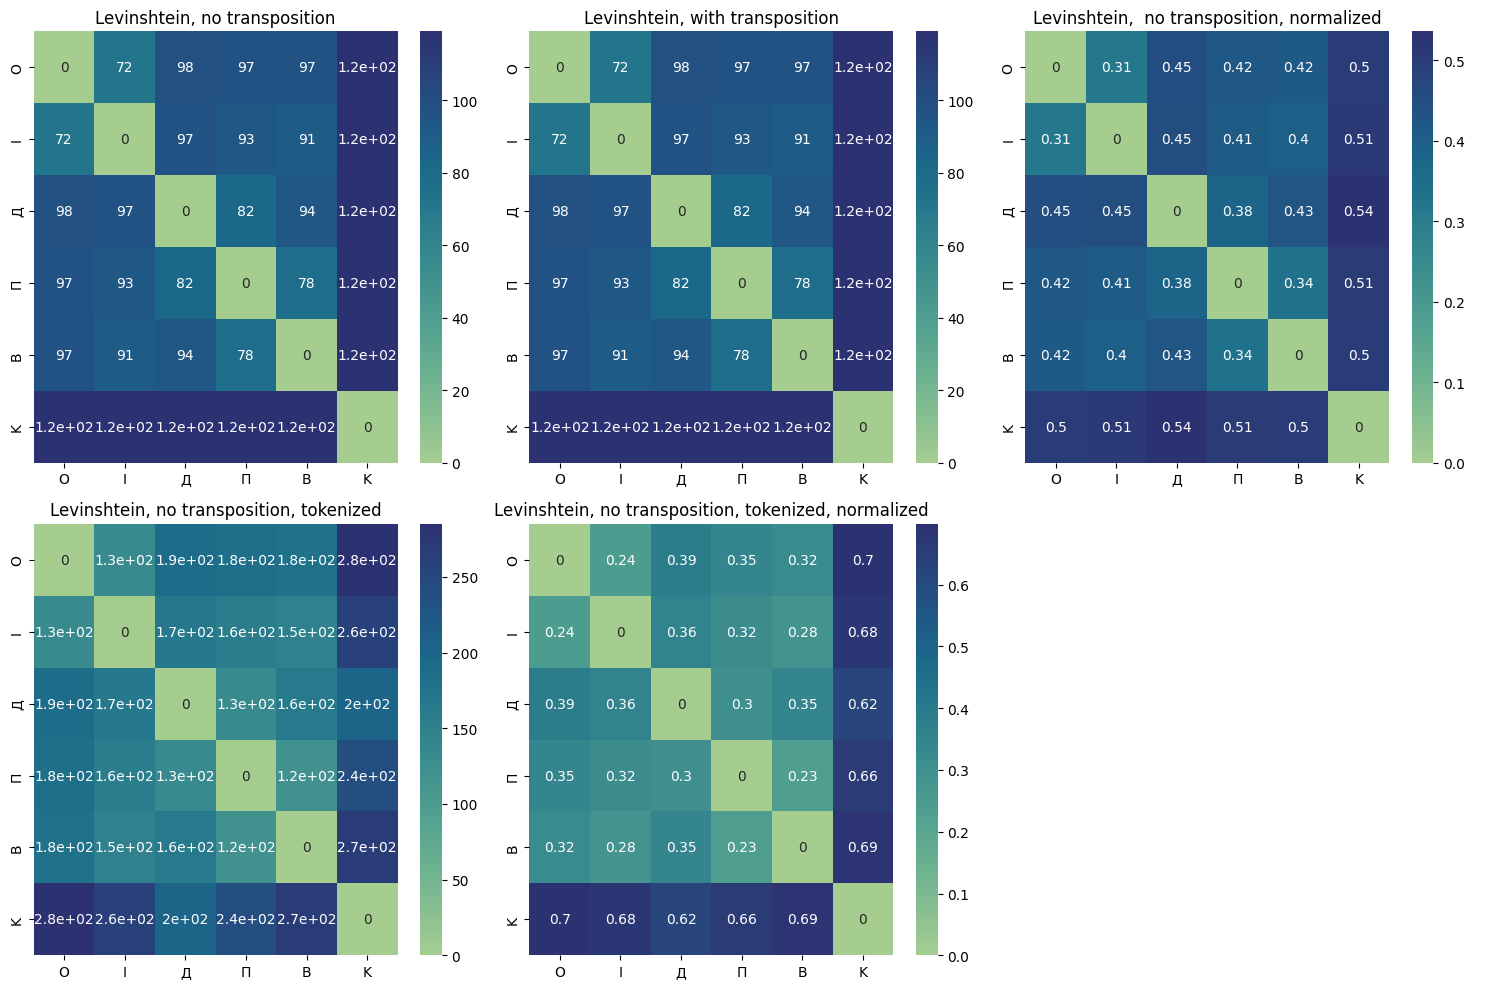

In [88]:
data = get_metrics_matrices(
    [dataset['O'], dataset['I'], dataset['Д'], dataset['П'], dataset['В'], dataset['K']],
    [
        lambda x, y: levenshtein_distance_positions(x, y)['distance'],
        lambda x, y: edit_distance(x,y, substitution_cost=1, transpositions=True),
        lambda x, y: levinshtein_distance_norm(x, y),
        lambda x, y: levenshtein_distance_positions(tokenize(x, old_slavonic_vocab),tokenize(y, old_slavonic_vocab))['distance'],
        lambda x, y: levinshtein_distance_norm(tokenize(x, old_slavonic_vocab),tokenize(y, old_slavonic_vocab))
    ],
    [
        'Levinshtein, no transposition',
        'Levinshtein, with transposition',
        'Levinshtein,  no transposition, normalized',
        'Levinshtein, no transposition, tokenized',
        'Levinshtein, no transposition, tokenized, normalized'
    ],
    axis_labels=['O', 'I', 'Д', 'П', 'В', 'K']
)